# Building a Simple Molecular Force Field with Python

> This  jupyter-notebook contains some commented code showing  how to build a simple molecular forcefield with Python.
- toc: True
- metadata_key1: forcefield
- metadata_key2: lennard-jones cluster


This  jupyter-notebook contains some commented code showing  how to build a simple molecular forcefield with Python using the libraries numpy and scipy. It is hosted on the [google colab platform](https://colab.research.google.com/drive/1nxv8pMykWkkahoVp3kKmO7IBPPtziUsD) and only a web browser is needed to run it.

Force Field are used to determine molecular structures and their respective (relative) energies. They are used in very different settings, ranging from drug development to materials research.

Usually empirical potential energy functions are used that map  the atomic coordinates of a specifc configuration for a molecular, cluster or crystal $\textbf{X}$ to an scalar energy value $E$. $\textbf{X}$ just contains the (e.g. cartesian) coordinates of all the atoms in vector or matrix form. As the atomic positions are changed so changes the total energy.   <br>

$E = f(\textbf{X})$

Variations of the atomic coordinates may then be carried out in order to find a (local) minimum of the energy, or more exact of the so-called potential energy surface (PES). If the gradient of the energy function is given, the efficiency of the optimization process can be significantly improved. Analytical gradients are functions that map the coordinates to a vector field giving the direction of the strongest rate of function value change at the point $\textbf{X}$.

Hence, energy and gradient evaluations are typical made for a given atomic configuration, the coordinates are updated with this information from the gradients, and a new configuration  $\textbf{X}'$ is obtained. This process is iterated until the energy or the gradient does not change anymore with respect to a given threshold.

To further characterize those states, 2nd order derivatives of the PES are also sometimes computed.


***
##Optimizing Lennard-Jones Cluster
In order to construct our own little Force Field we deal with a very simple model system. Lennard-Jones clusters are atomic ensembles which are held together only by comparatively weak Van der Waals (VdW) Forces. No strong bonds are involved such as covalent bonds or hydrogen bonds, which typically define real molecules. However, the lack of directed bonds renders this system somewhat easier to treat. The VdW forces are experienced by all atoms and only depend on the interatomic distance:


$E = 4\epsilon\sum_{i<j}\bigg[\bigg( \frac{\sigma}{r_{ij}}\bigg)^{12}-\bigg( \frac{\sigma}{r_{ij}}\bigg)^{6}\bigg]$

## Coding
First we import the necessary libraries. In particular numpy (http://www.numpy.org/) for linear algebra and scipy (https://www.scipy.org/) for some  handy functions such as different optimizers. Its always a good idea not to re-invent the wheel...

In [0]:
import numpy as np
from io import StringIO
from scipy.optimize import minimize
from scipy.optimize import basinhopping

Let us define the computation of the energy in a separate function.  Here its useful to introduce the concept of the distance matrix, which is a $n_{atoms} \times n_{atoms}$ matrix containing all the possible distances between the atoms of the system. Effectively, we compute only the upper triangular part of the distance matrix, as only unique distances are needed.

In [0]:
def calc_energy(coords,epsilon=1.0,sigma=1.0):
  #reshape coordinates to original 2D array
  tmpv = coords.reshape((natoms,3))
  E=0.0
  for i in range(natoms):
    for j in range(i+1,natoms):      
      distv = tmpv[i] - tmpv[j]
      d = np.linalg.norm(distv)
      E += ((sigma/d)**12-(sigma/d)**6)        
  
  E = 4*epsilon*E
  return(E)

Defining the random seed for reproducibility. We want to get the same results for the same input in case we use a stochastic process.

In [0]:
np.random.seed(42)

Let us parameterize the size of the system, so we can change it later on. Be careful not to enter too large integers here, computations may become quite costly.

In [0]:
natoms = 5

Generating some  random arrays via numpy, representing the initial atomic coordinates. Those will be far away from the minimum geometry, but we have to start somewhere. In this case we use  a $n_{atoms} \times 3$ matrix, containing in each row the x,y,z coordinates of an atom.<br>
For later use, we then  reshape the coordinates into a 1D vector, because the scipy minimize function expects this shape. 

In [0]:
coords = np.random.random((natoms,3))
coords = coords.reshape((natoms*3,))
coords


array([0.03438852, 0.9093204 , 0.25877998, 0.66252228, 0.31171108,
       0.52006802, 0.54671028, 0.18485446, 0.96958463, 0.77513282,
       0.93949894, 0.89482735, 0.59789998, 0.92187424, 0.0884925 ])

Lets call and test the energy function, which we have defined earlier. It should give a rather large value, due to the randomness of the coordinates used as initial input.

## Energies and Structure Optimisation

In [0]:
calc_energy(coords)

28134.0478850889

Now lets minimze the energy via the internal scipy minimize function. It containts a lot of different varations of minimizers, one is the Nealder-Mead simplex
method (by the way, not to be confused with the "simplex" method used in linear programming).<br>
The Nealder-Mead simplex does not need any gradients and hence is quite useful if no gradients are available. <br>For better performance we will have to implement gradients later on.

In [0]:

res = minimize(calc_energy, x0=coords, method='Nelder-Mead', tol=1e-6)
print("Energy: %16.6f after %d function evaluations using the simplex optimizer."%(res.fun,res.nfev))
coords_opt = res.x.reshape((natoms,3))


Energy:        -9.103852 after 2323 function evaluations using the simplex optimizer.


Ok lets try another minimizer, the Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm.

In [0]:
res = minimize(calc_energy, x0=coords, method='BFGS', tol=1e-6)
print("Energy: %16.6f after %d function evaluations using Broyden-Fletcher-Goldfarb-Shanno algorithm."%(res.fun,res.nfev))
coords_opt = res.x.reshape((natoms,3))

Energy:        -9.103852 after 3802 function evaluations using Broyden-Fletcher-Goldfarb-Shanno algorithm.


## Global optimisation

We just performed a local optimisation and hence it is possible that we missed the energetically lowest structure.

A global optimisation algorithm is ussually applied in order to to find the energetically lowest structure. Of course, we can never be 100% sure that we did not miss a lower energy structure with our search.

However, for this kind of small clusters however the possibilities are limited and we should have an energy of E=-6.0000 for 4 atom and E=-9.103 852 for 5 atoms. The difference between a normal optimisation and a global one will be much more significant for larger atom numbers. But be careful, computation will also like increase. 

For pre-computed results on larger systems and on details of the basin-hopping algorithm have a look at:

D. J. Wales and J. P. K. Doye
The Journal of Physical Chemistry A **1997** 101 (28), 5111-5116.<br>
 (http://www-wales.ch.cam.ac.uk/pdf/JPCA.101.5111.1997.pdf)



In [0]:
res = basinhopping(calc_energy, x0=coords_opt,niter=100,T=1.0, stepsize=0.5)
print("Energy: %16.6f after %d iterations."%(res.fun,res.nfev))

Energy:        -9.103852 after 234060 iterations.


### Visualization

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

Now some visualization to inspect the results.




(-3.0, 3.0)

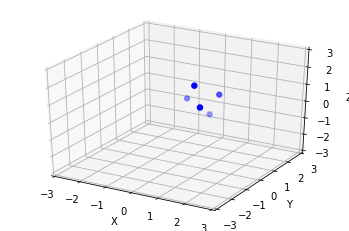

In [0]:
ax = plt.axes(projection='3d')
ax.scatter(coords_opt[:,0], coords_opt[:,1], coords_opt[:,2], c='blue', linewidth=2.0);
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
limits = (-3.0,3.0)
ax.set_xlim(limits)
ax.set_ylim(limits)
ax.set_zlim(limits)

### Gradients

Now lets implement a gradient function here to improve optimization performance.

In [0]:
def calc_gradient(coords,epsilon=1.0,sigma=1.0):
  #reshape coordinates to original 2D array
  tmpv = coords.reshape((natoms,3))
  E=0.0
  grad = np.zeros(natoms*3)
  for i in range(natoms):
    for j in range(i+1,natoms):      
      distv = tmpv[i] - tmpv[j]
      d = np.linalg.norm(distv)
      E += ((sigma/d)**12-(sigma/d)**6)
      grad_ = -12 * (d/sigma)**(-13) + 6* (d/sigma)**(-7)
      grad[i] = grad[i] + grad_
      grad[j] = grad[j] - grad_           
  
  E = 4*epsilon*E
  grad = 4*epsilon*grad
  grad = grad.reshape((natoms*3,))
  return(grad)
    

For optimization we use the BFGS algorithm again, but this time with analytical gradient.

In [0]:

res = minimize(calc_energy, x0=coords_opt, method='BFGS', jac=calc_gradient, tol=1e-6)
print("Energy: %16.6f after %d function evaluations using gradient info."%(res.fun,res.nfev))



Energy:        -9.103852 after 98 function evaluations using gradient info.


For a global optimzation we need a different strategy to ensure that we do not land in a local minimum. To use the scipy basin
hopin algorithm we to restructure the energy and the gradient function somewhat:

In [0]:
def calc_energy_with_gradient(coords, epsilon=1.0,sigma=1.0):
  E = calc_energy(coords,epsilon,sigma)
  grad = calc_gradient(coords,epsilon,sigma)
  return(E,grad)

In [0]:
minimizer_kwargs = {"method":"L-BFGS-B", "jac":True}
res = basinhopping(calc_energy_with_gradient, x0=coords_opt,niter=1000,T=5.0, stepsize=1,minimizer_kwargs=minimizer_kwargs)
print("Energy: %16.6f after %d function evaluations."%(res.fun,res.nfev))

Energy:        -9.103852 after 5387 function evaluations.


## Outlook: More Complex Force Fields
Usually, molecular Force Fields contain also directed interactions such as covalent or hydrogen bonds, in addition to VdW interactions. 

They very much resemble a spring and beads model where the atoms in a molecule are held together by a spring.
The atomic connections i.e. covalent bonds between atoms have to be defined beforehand. Each bond is modelled in first order by a spring, which exerts
a force on the atoms which increases linear with the distance from the equilibrium bond length. Hence, each characteristic bond (C-C single bond, C=C double bond, O-H bond etc.) can be represented by a spring constant. 

Due to the fact that all bonds are determined beforehand, no bonds can be made or be broken in typical Force Fields, in fact no real *chemistry* can take place, as opposed to quantum chemistry.

In addition to those covalent bond terms, angle terms, dihedral terms, Van der Waals terms and some special terms are sometimes added to the overall energy function.
The terms can be divided in bonded (e.g valence) terms $E_{val}$ and non-bonded terms $E_{nb}$ (see also J. Phys. Chem, Vol. 94, No. 26, 1990):

$E = E_{val}+E_{nb}$

The valence interaction typically consist out of bond stretch ($E_{B}$, two-body), bond-angle bend ($E_{A}$, three body) and dihedral angle torsion ($E_{T}$, four body), and inversion terms ($E_I$, four body).


$E_{val}=E_{B}+E_{A}+E_{T}+E_{I}$


The non-bonded interactions can may consist out of van der Waals or dispersion ($E_{vdW}$), electrostatic ($E_Q$) and explicit hydrogen bonding terms ($E_{hb}$):

$E_{nb}=E_{vdW}+E_{Q}+E_{hb}$

The global optimisation of this kind of energy function corresponds to a conformer search, where the global energy minimum represents  the most stable molecular conformation.

Molecular Force Field have their drawbacks such as their sometimes weak overall accuracy and lack of generality. But their are magnitudes faster than typical quantum chemical methods and are still in whitespread use.

The algorithms to optimize their structure are the same as for the more sophisticated quantum chemical methods.